In [2]:
from keras.datasets import fashion_mnist
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
import matplotlib as plt
from matplotlib import figure
from sklearn.mixture import GaussianMixture
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.
/home/gulfam_ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gulfam_ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gulfam_ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gulfam_ubuntu/.local/lib/python3.6/sit

In [3]:
#Fashion MNSIT data load from keras
(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()

xtrain = xtrain.reshape((xtrain.shape[0], -1))
xtest = xtest.reshape((xtest.shape[0], -1))
xtrain = xtrain.astype('float32')/255
xtest = xtest.astype('float32')/255

#print(xtrain.shape)
#print(xtest.shape)
#print(ytrain.shape)
#print(ytest.shape)

TASK 1: Accuracy of KMeans clustering model:  50.33277680079906 % 

Confusion Matrix:


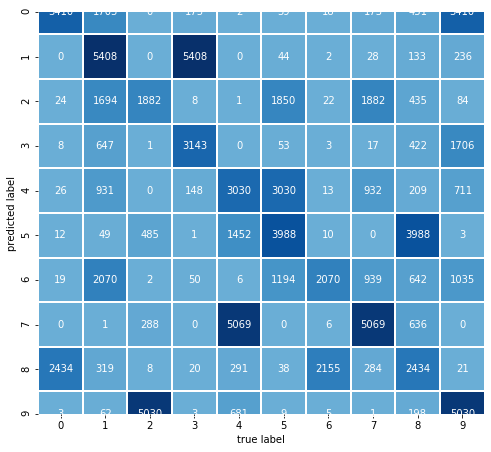

In [4]:
######################## TASK 1- K-Means clustering model #########################
kmeans = KMeans(n_clusters = 10, n_init = 20, n_jobs = -1)
ypred = kmeans.fit_predict(xtrain)

accuracy = metrics.adjusted_mutual_info_score(ytrain, ypred)
print('TASK 1: Accuracy of KMeans clustering model: ', accuracy*100, '%', '\n')

print("Confusion Matrix:" )
conf_mat = confusion_matrix(ytrain, ypred)

#Confusion matrix construction based on max values for each clusters
j=0
plt.figure(figsize=(8,8))
for i in range (10):
    maximum = np.max(conf_mat[i])
    #print(maximum)
    conf_mat[i,j]= maximum
    j=j+1
sns.heatmap(conf_mat, annot=True, square=True, fmt="d", cbar=False, center=0, linewidth=1, cmap="Blues", xticklabels=np.unique(ytrain), yticklabels=np.unique(ytrain))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [5]:
# input dimension = 784
input_dim = xtrain.shape[1]
encoding_dim = 128

In [6]:
#AutoEncoder implementation
autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu'),
)

autoencoder.add(
    Dense(input_dim, activation='sigmoid'),
)

autoencoder.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [7]:
#AutoEncoder compilation to train the fashion MNSIT data

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(xtrain, xtrain,
                epochs=40,
                batch_size=128,
                shuffle=True,
                validation_data=(xtest, xtest))



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 107us/step - loss: 0.0333 - val_loss: 0.0169
Epoch 2/40
60000/60000 [==============================] - 5s 80us/step - loss: 0.0136 - val_loss: 0.0115
Epoch 3/40
60000/60000 [==============================] - 5s 81us/step - loss: 0.0104 - val_loss: 0.0096
Epoch 4/40
60000/60000 [==============================] - 5s 82us/step - loss: 0.0089 - val_loss: 0.0084
Epoch 5/40
60000/60000 [==============================] - 5s 82us/step - loss: 0.0080 - val_loss: 0.0077
Epoch 6/40
60000/60000 [==============================] - 5s 83us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 7/40
60000/60000 [==============================] - 5s 84us/step - loss: 0.0069 - val_loss: 0.0067
Epoch 8/40
60000/60000 [==============================] - 5s 84us/step - loss: 0.0066 - val_l

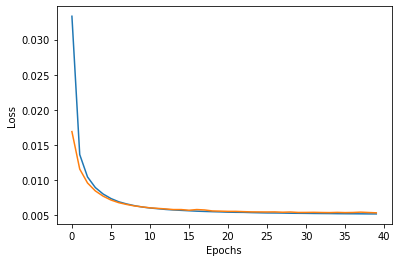

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [9]:
#Encoder module to get the compressed input version

input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________


TASK 2: Accuracy of KMeans model using Autoencoder:  45.275248502547285 % 

Confusion Matrix:


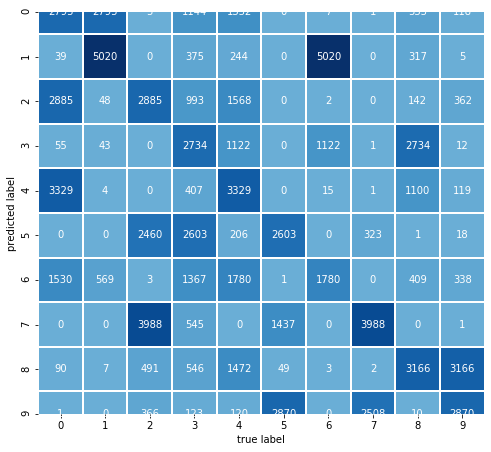

In [10]:
######################## TASK 2- Auto-Encoder based K-Means clustering model #########################
#Predict the encoded images
encoded_imgs = encoder.predict(xtrain)

#Perform KMeans on the encoded images with the true labels
kmeans = KMeans(n_clusters = 10, n_init = 20, n_jobs = -1)
ykmpred = kmeans.fit_predict(encoded_imgs)

accuracy = metrics.adjusted_mutual_info_score(ytrain, ykmpred)
print('TASK 2: Accuracy of KMeans model using Autoencoder: ', accuracy*100, '%', '\n')

print("Confusion Matrix:", )
conf_mat = confusion_matrix(ytrain, ykmpred)

#Confusion matrix construction based on max values for each clusters
j=0
plt.figure(figsize=(8,8))
for i in range (10):
    maximum = np.max(conf_mat[i])
    #print(maximum)
    conf_mat[i,j]= maximum
    j=j+1
sns.heatmap(conf_mat, annot=True, square=True, fmt="d", cbar=False, center=0, linewidth=1, cmap="Blues", xticklabels=np.unique(ytrain), yticklabels=np.unique(ytrain))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

TASK 3: Accuracy of GMM model using Autoencoder:  58.008174617592054 % 

Confusion Matrix:


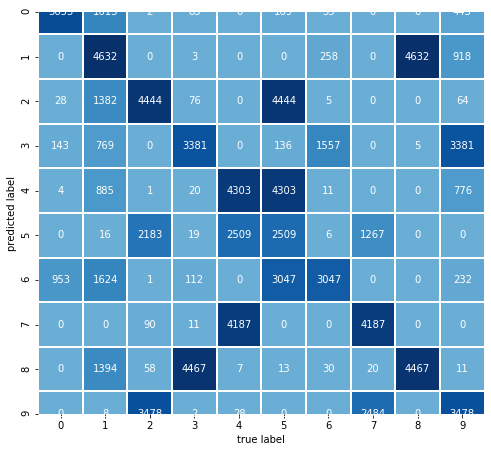

In [11]:
######################## TASK 3- Auto-Encoder based Gaussian Mixture Model clustering model #########################

encoded_imgs2 = encoder.predict(xtrain)
gm = GaussianMixture(n_components = 10, n_init = 2)
ygmpred = gm.fit(encoded_imgs2)
ygmpred = gm.predict(encoded_imgs2)

accuracy = metrics.adjusted_mutual_info_score(ytrain, ygmpred)
print('TASK 3: Accuracy of GMM model using Autoencoder: ', accuracy*100, '%', '\n')


print("Confusion Matrix:", )
conf_mat = confusion_matrix(ytrain, ygmpred)

#Confusion matrix construction based on max values for each clusters
j=0
plt.figure(figsize=(8,8))
for i in range (10):
    maximum = np.max(conf_mat[i])
    #print(maximum)
    conf_mat[i,j]= maximum
    j=j+1
sns.heatmap(conf_mat, annot=True, square=True, fmt="d", cbar=False, center=0, linewidth=1, cmap="Blues", xticklabels=np.unique(ytrain), yticklabels=np.unique(ytrain))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

Original Image:


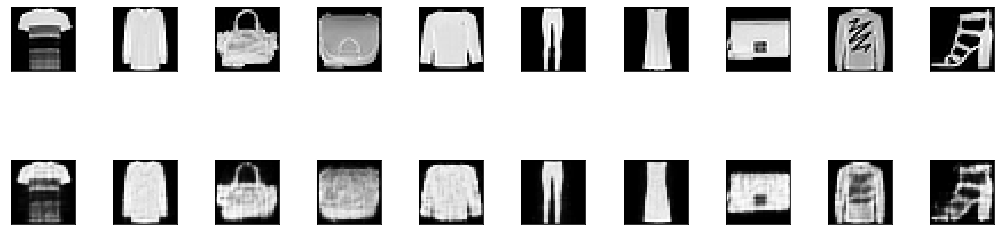

Reconstructed Image:


In [21]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(xtest.shape[0], size=num_images)

encoded_imgs = encoder.predict(xtest)
decoded_imgs = autoencoder.predict(xtest)

plt.figure(figsize=(18, 4))

print("Original Image:")  
for i, image_idx in enumerate(random_test_images):
    # plot original image

    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(xtest[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image

    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
print("Reconstructed Image:")